# Analysis of the interest of books on Twitter

In [2]:
# import of librairies
import time
import pandas as pd
from snscrape.modules.twitter import TwitterSearchScraper
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk

# Grabing tweet from tweeter : the art of war book

In [2]:
# Vincent function for scrapping tweeter
class Scraper:

    def __init__(self, format=""):
        
        """
        À l'origine le scraper devait aussi gérer le JSON, d'où le paramètre format.
        Valeurs possibles : 
        - "csv" pour enregistrer les résultats dans un csv
        - n'importe quelle autre valeur si vous voulez juste afficher les résultats dans la console
        """

        self.supported_formats = ["csv"]
        if format in self.supported_formats:
            self.format = format
            self.display_only = False
        else:
            print(f"WARNING: format {format} is not supported. Switching to display only")
            self.display_only = True
            return



    def scrape(self, filepath=None, query=None, results_count=0, language="en"):
        
        """
        Paramètres :
        - filepath : chemin vers le fichier où vous voulez enregistrer vos données
        - query : la recherche que vous voulez effectuer
        - results_count : le nombre de résultats voulus
        - language : la langue de recherche ("en" pour anglais, "fr" pour français)
        """


        tweets_max_time = int(time.time()) - 604800

        search = query + " lang:" + language + " since:2022-06-01"
        required_fields = ["id", "url", "date", "renderedContent", "hashtags", "replyCount", "retweetCount", "likeCount"]

        scraped_data = []
        tweets_processed = 0
        chunk_size = 10000

        while tweets_processed < results_count:
            scraping_results = TwitterSearchScraper(search).get_items()
            while tweets_processed < results_count:
                try:
                    tweet = next(scraping_results)
                    tweet.renderedContent = '''%s''' % tweet.renderedContent
                    if tweet.hashtags:
                        tweet.hashtags = str(tweet.hashtags).lstrip('[').rstrip(']')
                        tweet.hashtags = '''%s''' % tweet.hashtags

                except (TypeError, KeyError):
                    continue
                except StopIteration:
                    tweets_max_time -= 3000
                    search = query + " lang:" + language + " until_time:" + str(tweets_max_time)
                    break
                tweets_processed+=1
                if tweets_processed % 100 == 0:
                    print(str(tweets_processed) + " tweets scraped")
                scraped_data.append(tweet)
                if tweets_processed % chunk_size == 0:
                    print("Saving data chunk")
                    scraped_data = pd.DataFrame(scraped_data)[required_fields]
                    self.output(scraped_data)
                    scraped_data = []

        print("Final save")
        if scraped_data != []:
            scraped_data = pd.DataFrame(scraped_data)[required_fields]
            self.output(scraped_data, filepath)

    def output(self, scraped_data, filepath):

        """Ici, on enregistre ou affiche les résultats"""
        if self.display_only:
            print(scraped_data)
        elif self.format == "csv":
            scraped_data.to_csv(filepath, index=False, sep ='|')

In [18]:
#Test this function for the Art of War book
book_tweet = Scraper(format="csv")
book_tweet.scrape(query="the Art of War", language="en", results_count=1000, filepath="art_of_war.csv")

100 tweets scraped
200 tweets scraped
300 tweets scraped
400 tweets scraped
500 tweets scraped
600 tweets scraped
700 tweets scraped
800 tweets scraped
900 tweets scraped
1000 tweets scraped
Final save


In [4]:
df = pd.read_csv('art_of_war.csv', delimiter = '|')
df.head()

,id,url,date,renderedContent,hashtags,replyCount,retweetCount,likeCount
0,1610264281215369216,https://twitter.com/EduG2k/status/161026428121...,2023-01-03 13:18:16+00:00,@archer_kwaku Abi he no dey social media so we...,NaN,1,0,0
1,1610260928687218695,https://twitter.com/SunTzuSoccer/status/161026...,2023-01-03 13:04:57+00:00,@msceducation “Everyone will be able to see ho...,NaN,0,0,0
2,1610260894956810241,https://twitter.com/ArtofWarBot/status/1610260...,2023-01-03 13:04:49+00:00,"In the practical art of war, the best thing of...",NaN,0,0,0
3,1610260739641729025,https://twitter.com/pr0m37h3um/status/16102607...,2023-01-03 13:04:12+00:00,every dude (including girls) has had a point i...,NaN,1,0,0
4,1610260185536430082,https://twitter.com/bramiozo/status/1610260185...,2023-01-03 13:02:00+00:00,@lexfridman A lot of the books I see require d...,NaN,0,0,0


# Creating a Wordcloud

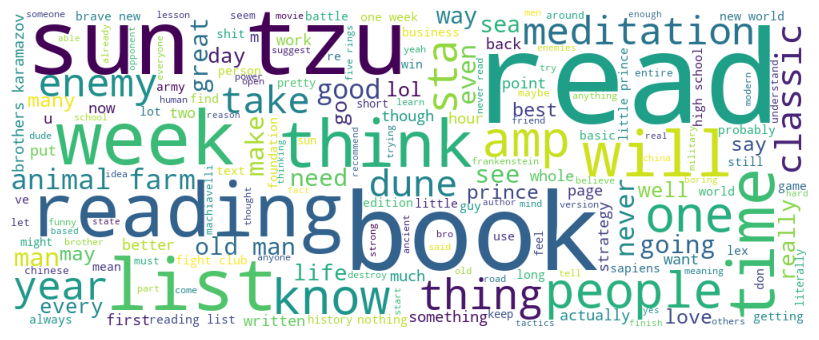

In [6]:
# Creat a wordcloud from DataFrame generated erlier.

comment_words = ''
stopwords = set(STOPWORDS)
stop_words = ["https", "co", "RT","twitter","t","amazon","war","art","dp","lexfridman","s"] + list(STOPWORDS)


for val in df.renderedContent:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 1000, height = 400,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Automatisation for other books

We will automate the scrapping and the generation of the wordcloud, to be able to do the 5 books at once.

In [9]:
#the list of books to be analyzed 
books = ['the Art of War', 'The song of Achille', 'Batman : the Dark Night Return', 'The Picture of Dorian Gray', 'The Book Thief']

In [28]:
#function for scrapping book data on tweeter
def scrappy(book_name):
    csv_name = book_name.lower().replace(' ', '_')
    book = Scraper(format="csv")
    book.scrape(query=book_name, language="en", results_count=1000, filepath=csv_name+".csv")

In [7]:
#function for creat wordcloud
def wordcloudy(book_name):
    
    csv_name = book_name.lower().replace(' ', '_')
    df = pd.read_csv(csv_name+'.csv', delimiter = '|')
    
    comment_words = ''
    stopwords = set(STOPWORDS)
    stop_words = ["https", "co", "RT","twitter","t","amazon","war","art","dp","lexfridman","s"] + list(STOPWORDS)


    for val in df.renderedContent:
     
        val = str(val)
 
        tokens = val.split()
     
    # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
     
        comment_words += " ".join(tokens)+" "
 
    wordcloud = WordCloud(width = 1000, height = 400,
                    background_color ='white',
                    stopwords = stop_words,
                    min_font_size = 10).generate(comment_words)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
 
    plt.show()

In [32]:
# functions are in different loops to avoid restarting the scrapping each time. 
# loop for apply scrappy function on each book in the list books
for book in books :
    print(book)
    scrappy(book)

the Art of War
100 tweets scraped
200 tweets scraped
300 tweets scraped
400 tweets scraped
500 tweets scraped
600 tweets scraped
700 tweets scraped
800 tweets scraped
900 tweets scraped
1000 tweets scraped
Final save
The song of Achille
100 tweets scraped
200 tweets scraped
300 tweets scraped
400 tweets scraped
500 tweets scraped
600 tweets scraped
700 tweets scraped
800 tweets scraped
900 tweets scraped
1000 tweets scraped
Final save
Batman : the Dark Night Return
100 tweets scraped
200 tweets scraped
300 tweets scraped
400 tweets scraped
500 tweets scraped
600 tweets scraped
700 tweets scraped
800 tweets scraped
900 tweets scraped
1000 tweets scraped
Final save
The Picture of Dorian Gray
100 tweets scraped
200 tweets scraped
300 tweets scraped
400 tweets scraped
500 tweets scraped
600 tweets scraped
700 tweets scraped
800 tweets scraped
900 tweets scraped
1000 tweets scraped
Final save
The Book Thief
100 tweets scraped
200 tweets scraped
300 tweets scraped
400 tweets scraped
500 twee

the Art of War


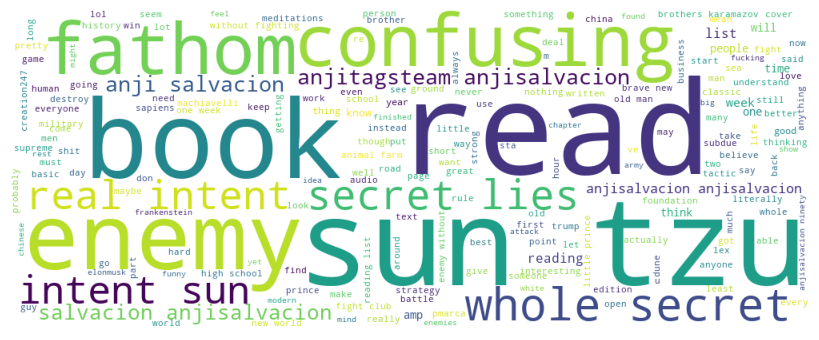

The song of Achille


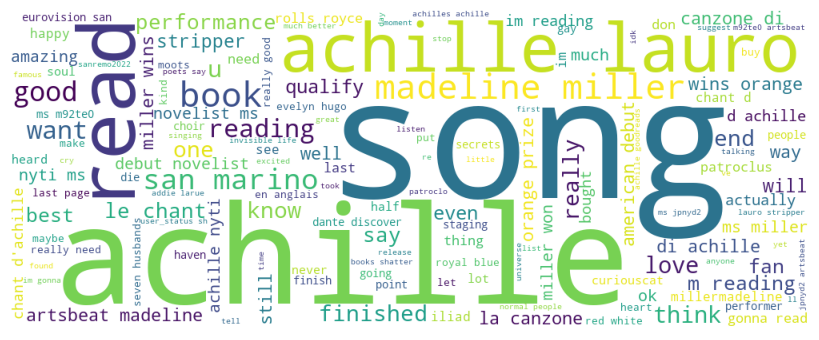

Batman : the Dark Night Return


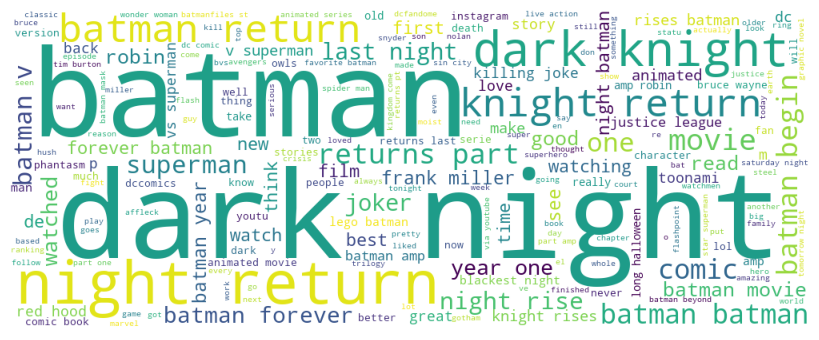

The Picture of Dorian Gray


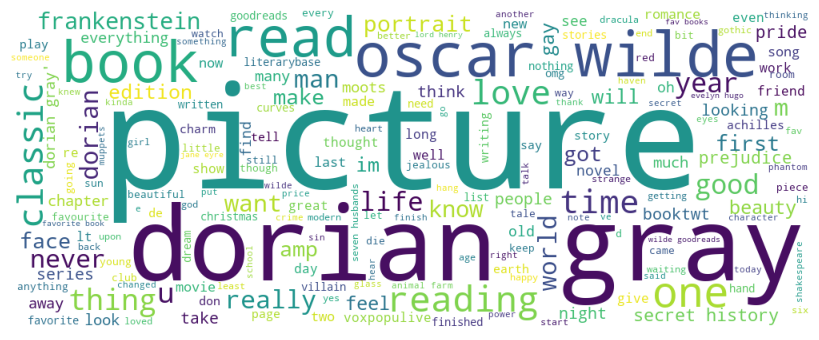

The Book Thief


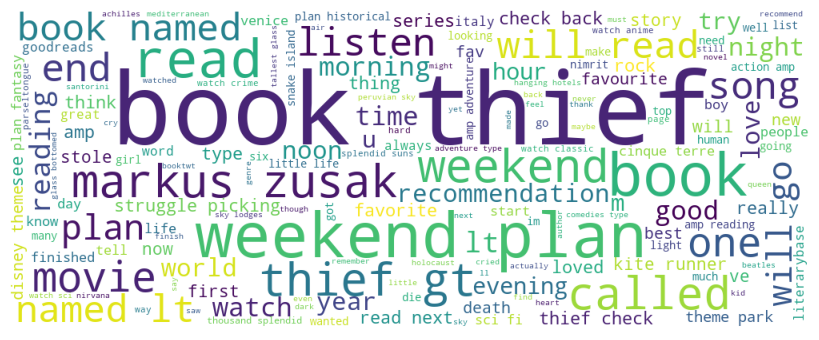

In [10]:
# loop for apply wordcloudy function on each book in the list books
for book in books:
    print(book)
    wordcloudy(book)

# Bigram and trigram

In [11]:
word_data = "The best performance can bring in sky high success."
nltk_tokens = nltk.word_tokenize(word_data)  	

print(list(nltk.bigrams(nltk_tokens)))

[('The', 'best'), ('best', 'performance'), ('performance', 'can'), ('can', 'bring'), ('bring', 'in'), ('in', 'sky'), ('sky', 'high'), ('high', 'success'), ('success', '.')]


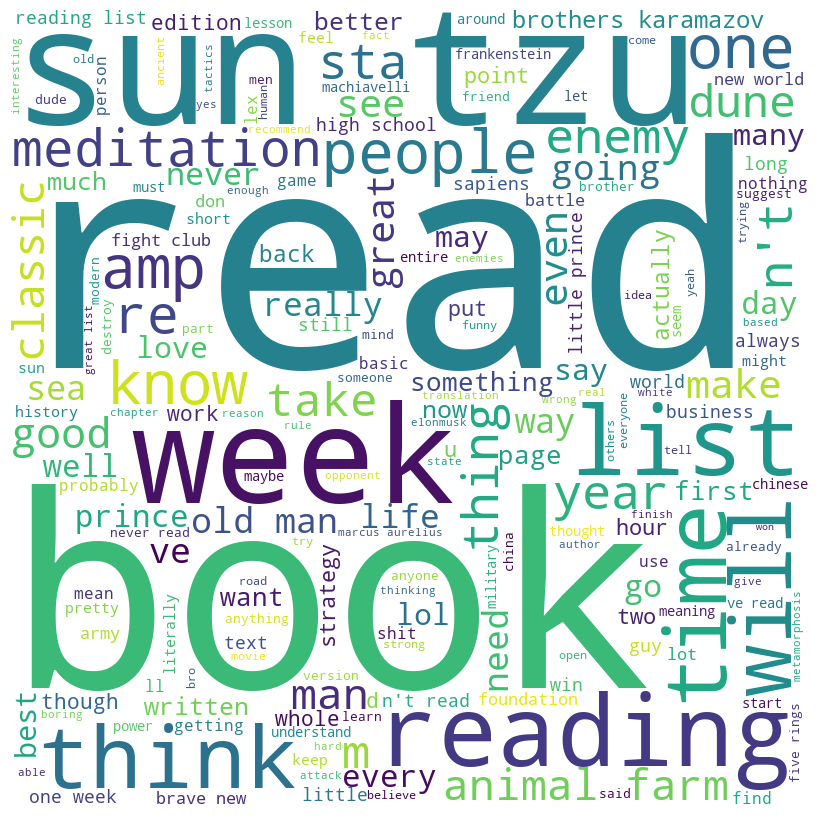

In [52]:
comment_words = ''
stopwords = set(STOPWORDS)
stop_words = ["https", "co", "RT","twitter","t","amazon","war","art","dp","lexfridman","s"] + list(STOPWORDS)


for val in df.renderedContent:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = nltk.word_tokenize(val)
    bigram = nltk.bigrams(tokens)
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        
    bigram = nltk.bigrams(tokens)
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
import nltk
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
fourgram_measures = nltk.collocations.QuadgramAssocMeasures()
finder = BigramCollocationFinder.from_words(bigram)
finder.nbest(bigram_measures.pmi, 10)